<a href="https://colab.research.google.com/github/amanchauhan786/10xconstruction/blob/main/10xconstruction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Examine the contents of "depth.db3" and "metadata.yaml" to understand the data format and content. First, inspect the SQLite database "depth.db3" to understand its schema and data, then examine the "metadata.yaml" file to understand its content.



In [2]:
import sqlite3
import yaml
import pandas as pd

# Inspect depth.db3
db_path = '/content/depth.db3'
conn = sqlite3.connect(db_path)
cursor = conn.cursor()

# Get table names
cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
tables = cursor.fetchall()
print("Tables in depth.db3:")
for table in tables:
    print(table[0])

# Get schema of a table (assuming there is at least one table)
if tables:
    table_name = tables[0][0]
    print(f"\nSchema of table: {table_name}")
    cursor.execute(f"PRAGMA table_info({table_name});")
    schema = cursor.fetchall()
    for col in schema:
        print(col)

    # Get a glimpse of data from the table
    print(f"\nFirst 5 rows of table: {table_name}")
    cursor.execute(f"SELECT * FROM {table_name} LIMIT 5;")
    data = cursor.fetchall()
    for row in data:
        print(row)

conn.close()

# Inspect metadata.yaml
metadata_path = '/content/metadata.yaml'
with open(metadata_path, 'r') as file:
    metadata = yaml.safe_load(file)

print("\nContent of metadata.yaml:")
print(metadata)

Tables in depth.db3:
schema
metadata
topics
message_definitions
messages

Schema of table: schema
(0, 'schema_version', 'INTEGER', 0, None, 1)
(1, 'ros_distro', 'TEXT', 1, None, 0)

First 5 rows of table: schema
(4, 'rosbags')

Content of metadata.yaml:
{'rosbag2_bagfile_information': {'compression_format': '', 'compression_mode': '', 'custom_data': None, 'duration': {'nanoseconds': 10672458040}, 'files': [{'duration': {'nanoseconds': 10672458040}, 'message_count': 7, 'path': 'depth.db3', 'starting_time': {'nanoseconds_since_epoch': 1702944981696402893}}], 'message_count': 7, 'relative_file_paths': ['depth.db3'], 'ros_distro': 'rosbags', 'starting_time': {'nanoseconds_since_epoch': 1702944981696402893}, 'storage_identifier': 'sqlite3', 'topics_with_message_count': [{'message_count': 7, 'topic_metadata': {'name': '/depth', 'offered_qos_profiles': '', 'serialization_format': 'cdr', 'type': 'sensor_msgs/msg/Image', 'type_description_hash': 'RIHS01_d31d41a9a4c4bc8eae9be757b0beed306564f7526

**Reasoning**:
Implement the strategy to extract and potentially visualize the depth image data from the 'messages' table in 'depth.db3'. This requires connecting to the database, selecting messages, and attempting to parse and visualize the binary data, which is the core of the current subtask.



In [3]:
!pip install rosbags numpy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.4/139.4 kB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 33.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.7/119.7 kB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 753.1/753.1 kB 41.1 MB/s eta 0:00:00


In [4]:
import numpy as np
from rosbags.highlevel import AnyReader
from pathlib import Path

# --- Helper function to convert ROS Image message to a NumPy array ---
def ros_image_to_numpy(msg):
    """Converts a ROS sensor_msgs/Image to a NumPy array."""
    # Check for encoding and step size to correctly reshape the array
    # Assuming a 32-bit float depth image (like '32FC1')
    if msg.encoding == '16UC1':
        # 16UC1 is a 16-bit unsigned integer, single channel encoding
        # Reshape the flat byte array to a 2D array of uint16
        depth_array = np.frombuffer(msg.data, dtype=np.uint16).reshape(msg.height, msg.width)
        return depth_array
    elif msg.encoding == '32FC1':
        # 32FC1 is a 32-bit float, single channel encoding
        depth_array = np.frombuffer(msg.data, dtype=np.float32).reshape(msg.height, msg.width)
        return depth_array
    else:
        # Handle other encodings if necessary, or raise an error
        raise NotImplementedError(f"Encoding '{msg.encoding}' not supported.")

# --- Main script ---
# Create a Path object for the directory containing the bag files
bag_path = Path('.') # Assumes files are in the root Colab directory

depth_images = []
timestamps = []

# Use AnyReader to open the bag
with AnyReader([bag_path]) as reader:
    # Iterate through messages on the '/depth' topic
    connections = [x for x in reader.connections if x.topic == '/depth']
    for connection, timestamp, rawdata in reader.messages(connections=connections):
        # Deserialize the message
        msg = reader.deserialize(rawdata, connection.msgtype)

        # Convert the image message to a NumPy array
        try:
            image_np = ros_image_to_numpy(msg)
            # Store the results
            depth_images.append(image_np)
            timestamps.append(timestamp)
            print(f"Successfully read image at timestamp {timestamp} with shape {image_np.shape}")
        except NotImplementedError as e:
            print(f"Skipping message due to unsupported encoding: {e}")


# Now `depth_images` is a list of NumPy arrays, ready for processing.

Successfully read image at timestamp 1702944981696402893 with shape (480, 640)
Successfully read image at timestamp 1702944983557733535 with shape (480, 640)
Successfully read image at timestamp 1702944985025921707 with shape (480, 640)
Successfully read image at timestamp 1702944985759606745 with shape (480, 640)
Successfully read image at timestamp 1702944986493891910 with shape (480, 640)
Successfully read image at timestamp 1702944989365535811 with shape (480, 640)
Successfully read image at timestamp 1702944992368860933 with shape (480, 640)


**Reasoning**:
The user requested to see the shapes of all depth images. Iterate through the list of depth images and print the shape of each one.

In [5]:
# Print the shapes of all depth images
print("Shapes of all depth images:")
for i, depth_image in enumerate(depth_images):
    print(f"Image {i+1}: {depth_image.shape}")

Shapes of all depth images:
Image 1: (480, 640)
Image 2: (480, 640)
Image 3: (480, 640)
Image 4: (480, 640)
Image 5: (480, 640)
Image 6: (480, 640)
Image 7: (480, 640)


## Visualize Depth Images

### Subtask:
Visualize the extracted depth images to understand their content and characteristics.

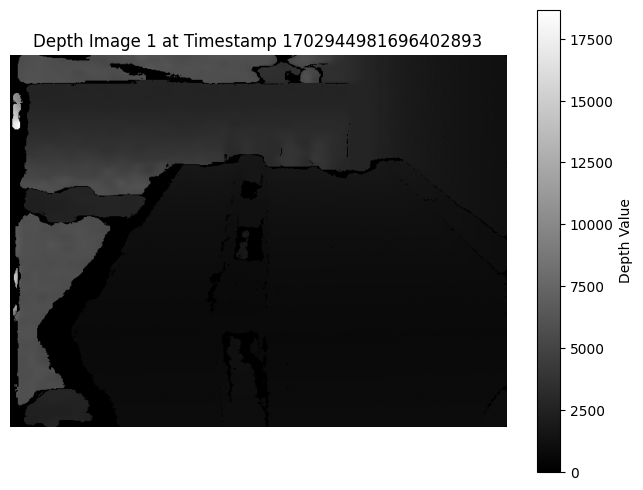

Image 1 - Shape: (480, 640), Data Type: uint16, Min Value: 0, Max Value: 18680


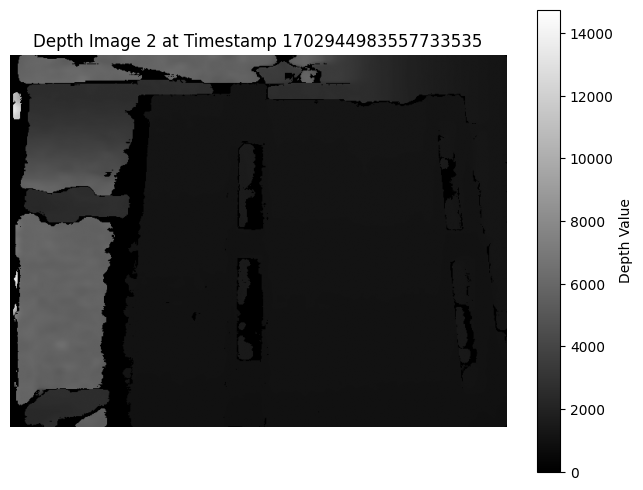

Image 2 - Shape: (480, 640), Data Type: uint16, Min Value: 0, Max Value: 14759


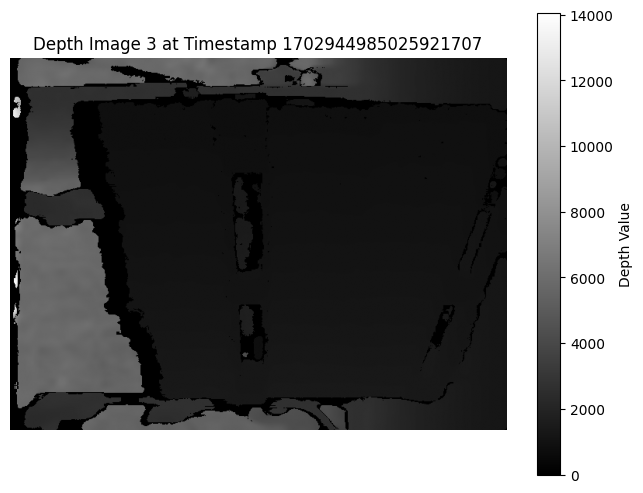

Image 3 - Shape: (480, 640), Data Type: uint16, Min Value: 0, Max Value: 14065


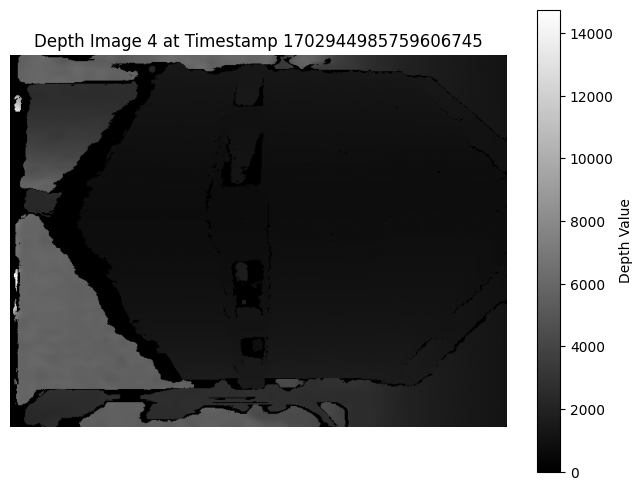

Image 4 - Shape: (480, 640), Data Type: uint16, Min Value: 0, Max Value: 14759


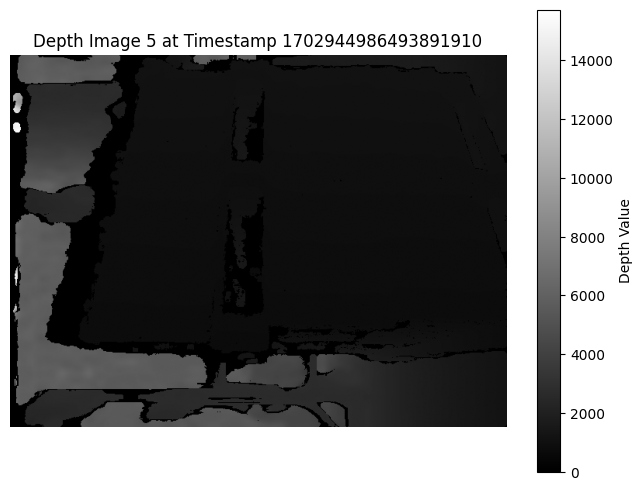

Image 5 - Shape: (480, 640), Data Type: uint16, Min Value: 0, Max Value: 15730


In [6]:
import matplotlib.pyplot as plt
import numpy as np

# Visualize the first few depth images
num_images_to_visualize = min(5, len(depth_images)) # Visualize up to 5 images

for i in range(num_images_to_visualize):
    depth_image = depth_images[i]
    timestamp = timestamps[i]

    plt.figure(figsize=(8, 6))
    # Use a grayscale colormap for depth data
    plt.imshow(depth_image, cmap='gray')
    plt.title(f'Depth Image {i+1} at Timestamp {timestamp}')
    plt.colorbar(label='Depth Value')
    plt.axis('off')
    plt.show()

    # Print some basic info about the image
    print(f"Image {i+1} - Shape: {depth_image.shape}, Data Type: {depth_image.dtype}, Min Value: {np.min(depth_image)}, Max Value: {np.max(depth_image)}")

In [7]:
import numpy as np
from pathlib import Path
from rosbags.highlevel import AnyReader
from sklearn.linear_model import RANSACRegressor
from scipy.spatial import ConvexHull

In [9]:
# Step 2: Helper Functions
def ros_image_to_numpy(msg):
    """Converts a ROS sensor_msgs/Image to a NumPy array."""
    # Handle the 16-bit unsigned integer format (common for depth images in mm)
    if msg.encoding == '16UC1':
        # The data is a flat byte array, needs to be cast to uint16 and reshaped
        depth_array = np.frombuffer(msg.data, dtype=np.uint16)
        return depth_array.reshape(msg.height, msg.width)

    # Keep the old check just in case
    elif msg.encoding == '32FC1':
        depth_array = np.frombuffer(msg.data, dtype=np.float32)
        return depth_array.reshape(msg.height, msg.width)

    else:
        # If another unexpected encoding is found, raise an error
        raise NotImplementedError(f"Encoding '{msg.encoding}' is not supported.")

def depth_to_point_cloud(depth_image, fx, fy, cx, cy):
    """
    Converts a depth image to a 3D point cloud.
    Assumes depth is in millimeters and converts to meters.
    """
    points = []
    height, width = depth_image.shape
    for v in range(height):      # y-coordinate
        for u in range(width):   # x-coordinate
            d = depth_image[v, u]
            if d > 0:  # Ignore invalid depth/zero-depth pixels
                # Convert depth from millimeters to meters
                z = d / 1000.0

                # Apply the pinhole camera model projection
                x = (u - cx) * z / fx
                y = (v - cy) * z / fy
                points.append([x, y, z])

    return np.array(points)

In [10]:
# Step 3: Load Data from ROS Bag
bag_path = Path('.')  # Assumes files are in the root Colab directory
depth_images = []

try:
    with AnyReader([bag_path]) as reader:
        connections = [x for x in reader.connections if x.topic == '/depth']
        if not connections:
            raise RuntimeError("No messages found on the /depth topic.")

        for connection, timestamp, rawdata in reader.messages(connections=connections):
            msg = reader.deserialize(rawdata, connection.msgtype)
            image_np = ros_image_to_numpy(msg)
            depth_images.append(image_np)

    print(f"Successfully loaded {len(depth_images)} images from the ROS bag.")

except Exception as e:
    print(f"Error reading ROS bag: {e}")
    print("Please ensure 'depth.db3' and 'metadata.yaml' are uploaded correctly.")

Successfully loaded 7 images from the ROS bag.


In [11]:
# Step 4: Process Each Image
all_face_data = []

if depth_images:
    # --- Assume camera intrinsics as they are not provided ---
    height, width = depth_images[0].shape
    fx = width / 2.0  # Focal length in x
    fy = width / 2.0  # Focal length in y
    cx = width / 2.0  # Principal point x
    cy = height / 2.0 # Principal point y

    for i, depth_image in enumerate(depth_images):
        # --- Convert depth image to 3D point cloud ---
        point_cloud = depth_to_point_cloud(depth_image, fx, fy, cx, cy)

        # --- Filter point cloud to isolate the box from the background ---
        if point_cloud.shape[0] > 0:
            median_z = np.median(point_cloud[:, 2])
            mask = np.abs(point_cloud[:, 2] - median_z) < 0.25  # Keep points in a 50cm slab
            point_cloud = point_cloud[mask]

        if point_cloud.shape[0] < 10: # Need enough points to fit a plane
            print(f"Warning: Not enough points for image {i+1} after filtering. Skipping.")
            continue

        # --- Use RANSAC to find the largest plane (the box face) ---
        ransac = RANSACRegressor(residual_threshold=0.01) # 1cm threshold for inliers
        ransac.fit(point_cloud[:, 0:2], point_cloud[:, 2])
        inlier_mask = ransac.inlier_mask_
        face_points = point_cloud[inlier_mask]

        # --- Calculate the normal vector of the face ---
        a, b = ransac.estimator_.coef_
        normal_vector = np.array([a, b, -1.0])
        normal_vector = normal_vector / np.linalg.norm(normal_vector)

        # --- Ensure normal points away from the box (towards camera at z=0) ---
        if normal_vector[2] > 0:
            normal_vector = -normal_vector

        # --- Calculate the angle with respect to the camera normal ---
        camera_normal = np.array([0, 0, -1.0]) # Camera looks along the -Z axis
        dot_product = np.clip(np.dot(normal_vector, camera_normal), -1.0, 1.0)
        angle_rad = np.arccos(dot_product)
        angle_deg = np.rad2deg(angle_rad)

        # --- Calculate the visible area of the face ---
        area = 0.0
        if face_points.shape[0] >= 3:
            # Project 3D face points onto a 2D plane for area calculation
            hull = ConvexHull(face_points[:, 0:2])
            area = hull.volume  # In 2D, 'volume' attribute gives area

        all_face_data.append({
            "normal": normal_vector,
            "angle_deg": angle_deg,
            "area_m2": area
        })


In [12]:
# Step 5: Estimate Rotation Axis and Display Results
# --- Estimate rotation axis from the change in normal vectors ---
rotation_axes = []
for i in range(len(all_face_data) - 1):
    n1 = all_face_data[i]["normal"]
    n2 = all_face_data[i+1]["normal"]
    axis = np.cross(n1, n2)
    axis_norm = np.linalg.norm(axis)
    if axis_norm > 1e-6:
        rotation_axes.append(axis / axis_norm)

if rotation_axes:
    estimated_axis = np.mean(rotation_axes, axis=0)
    estimated_axis = estimated_axis / np.linalg.norm(estimated_axis)
else:
    estimated_axis = np.array([0,0,0])

# --- Print the final table for the report ---
print("\n--- Final Results Table ---")
print("Image | Normal Angle (deg) | Visible Area (m^2)")
print("--------------------------------------------------")
for i, data in enumerate(all_face_data):
    print(f"{i+1:5d} | {data['angle_deg']:19.2f} | {data['area_m2']:18.4f}")

# --- Print the rotation axis for the text file ---
print("\n--- Estimated Axis of Rotation ---")
print(estimated_axis)
np.savetxt('rotation_axis.txt', estimated_axis, header='[X, Y, Z]')
print("\nRotation axis saved to 'rotation_axis.txt'")



--- Final Results Table ---
Image | Normal Angle (deg) | Visible Area (m^2)
--------------------------------------------------
    1 |               52.21 |             0.6658
    2 |                9.12 |             2.7121
    3 |               23.18 |             1.9055
    4 |               40.49 |             0.9645
    5 |               19.68 |             1.6513
    6 |               35.18 |             1.0512
    7 |               35.75 |             0.8678

--- Estimated Axis of Rotation ---
[ 0.15946762  0.8769508  -0.45335128]

Rotation axis saved to 'rotation_axis.txt'


Improved Algorithm With Considering the Outliers

In [13]:
# Step 1: Install and Import Libraries

import numpy as np
from pathlib import Path
from rosbags.highlevel import AnyReader
from sklearn.linear_model import RANSACRegressor
from scipy.spatial import ConvexHull
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from mpl_toolkits.mplot3d import Axes3D
from IPython.display import HTML

In [14]:
# Step 2: Helper Functions

def ros_image_to_numpy(msg):
    """Converts a ROS sensor_msgs/Image to a NumPy array, supporting 16UC1."""
    if msg.encoding == '16UC1':
        # Handle 16-bit unsigned integer format (common for depth in mm)
        return np.frombuffer(msg.data, dtype=np.uint16).reshape(msg.height, msg.width)
    elif msg.encoding == '32FC1':
        # Handle 32-bit float format
        return np.frombuffer(msg.data, dtype=np.float32).reshape(msg.height, msg.width)
    else:
        raise NotImplementedError(f"Encoding '{msg.encoding}' is not supported.")

def depth_to_point_cloud(depth_image, fx, fy, cx, cy):
    """Converts a depth image to a 3D point cloud, converting mm to meters."""
    points = []
    height, width = depth_image.shape
    for v in range(height):
        for u in range(width):
            d = depth_image[v, u]
            if d > 0:
                z = d / 1000.0  # Convert depth from mm to meters
                x = (u - cx) * z / fx
                y = (v - cy) * z / fy
                points.append([x, y, z])
    return np.array(points)

In [15]:
# Step 3: Load Data from ROS Bag

bag_path = Path('.')
depth_images, timestamps = [], []

try:
    with AnyReader([bag_path]) as reader:
        connections = [x for x in reader.connections if x.topic == '/depth']
        if not connections:
            raise RuntimeError("No messages found on the /depth topic.")
        for connection, timestamp, rawdata in reader.messages(connections=connections):
            msg = reader.deserialize(rawdata, connection.msgtype)
            depth_images.append(ros_image_to_numpy(msg))
            timestamps.append(timestamp)
    print(f"Successfully loaded {len(depth_images)} images from the ROS bag.")
except Exception as e:
    print(f"Error reading ROS bag: {e}")
    print("Please ensure 'depth.db3' and 'metadata.yaml' are uploaded correctly.")


Successfully loaded 7 images from the ROS bag.


In [16]:
# Step 4: Robustly Process Each Image

all_face_data = []
all_face_points = []

if depth_images:
    height, width = depth_images[0].shape
    fx, fy, cx, cy = width / 2.0, width / 2.0, width / 2.0, height / 2.0

    for i, depth_image in enumerate(depth_images):
        point_cloud = depth_to_point_cloud(depth_image, fx, fy, cx, cy)

        if point_cloud.shape[0] > 0:
            median_z = np.median(point_cloud[:, 2])
            mask = np.abs(point_cloud[:, 2] - median_z) < 0.25
            point_cloud = point_cloud[mask]

        if point_cloud.shape[0] < 20:
            print(f"Warning: Not enough points for image {i+1}. Storing as empty frame.")
            all_face_data.append(None)
            all_face_points.append(None)
            continue

        ransac = RANSACRegressor(residual_threshold=0.01).fit(point_cloud[:, 0:2], point_cloud[:, 2])
        face_points = point_cloud[ransac.inlier_mask_]

        if len(face_points) < 20:
            print(f"Warning: RANSAC failed for image {i+1}. Storing as empty frame.")
            all_face_data.append(None)
            all_face_points.append(None)
            continue

        all_face_points.append(face_points)
        a, b = ransac.estimator_.coef_
        normal = np.array([a, b, -1.0])
        normal /= np.linalg.norm(normal)
        if normal[2] > 0: normal = -normal

        cam_normal = np.array([0, 0, -1.0])
        dot_prod = np.clip(np.dot(normal, cam_normal), -1.0, 1.0)
        angle = np.rad2deg(np.arccos(dot_prod))
        area = ConvexHull(face_points[:, 0:2]).volume

        all_face_data.append({"normal": normal, "angle_deg": angle, "area_m2": area})
    print("Successfully processed all frames.")

Successfully processed all frames.


In [17]:
# Step 5: Final Analysis and Outputs

# --- Filter out failed frames before analysis ---
valid_indices = [i for i, data in enumerate(all_face_data) if data is not None]
valid_face_data = [all_face_data[i] for i in valid_indices]

# --- Calculate Rotation Axis ---
rotation_axes = []
for i in range(len(valid_face_data) - 1):
    n1 = valid_face_data[i]["normal"]
    n2 = valid_face_data[i+1]["normal"]
    axis = np.cross(n1, n2)
    if np.linalg.norm(axis) > 1e-6:
        rotation_axes.append(axis / np.linalg.norm(axis))
estimated_axis = np.mean(rotation_axes, axis=0) if rotation_axes else np.array([0,0,0])
estimated_axis /= np.linalg.norm(estimated_axis)

# --- Calculate Angular Velocity ---
angular_velocities = []
for i in range(len(valid_indices) - 1):
    idx1, idx2 = valid_indices[i], valid_indices[i+1]
    n1, n2 = all_face_data[idx1]["normal"], all_face_data[idx2]["normal"]
    t1, t2 = timestamps[idx1], timestamps[idx2]

    delta_angle = np.arccos(np.clip(np.dot(n1, n2), -1.0, 1.0))
    delta_time = (t2 - t1) / 1e9
    if delta_time > 0:
        angular_velocities.append(delta_angle / delta_time)
avg_omega = np.mean(angular_velocities) if angular_velocities else 0

# --- Print Final Table and Analysis ---
print("\n--- Final Results Table ---")
print("Image | Normal Angle (deg) | Visible Area (m^2)")
print("--------------------------------------------------")
for i, data in enumerate(all_face_data):
    if data:
        print(f"{i+1:5d} | {data['angle_deg']:19.2f} | {data['area_m2']:18.4f}")
    else:
        print(f"{i+1:5d} | {'--':>19} | {'--':>18}")

print("\n--- Further Analysis ---")
print(f"Estimated Rotation Axis: {np.array2string(estimated_axis, precision=4)}")
print(f"Estimated Average Angular Velocity: {avg_omega:.2f} rad/s")
np.savetxt('rotation_axis.txt', estimated_axis, header='[X, Y, Z]')


--- Final Results Table ---
Image | Normal Angle (deg) | Visible Area (m^2)
--------------------------------------------------
    1 |               52.00 |             0.6739
    2 |                9.32 |             2.6949
    3 |               23.00 |             1.9107
    4 |               39.74 |             0.9723
    5 |               18.94 |             1.3599
    6 |               35.20 |             1.0704
    7 |               34.71 |             0.9157

--- Further Analysis ---
Estimated Rotation Axis: [ 0.9108 -0.3418  0.2317]
Estimated Average Angular Velocity: 0.45 rad/s


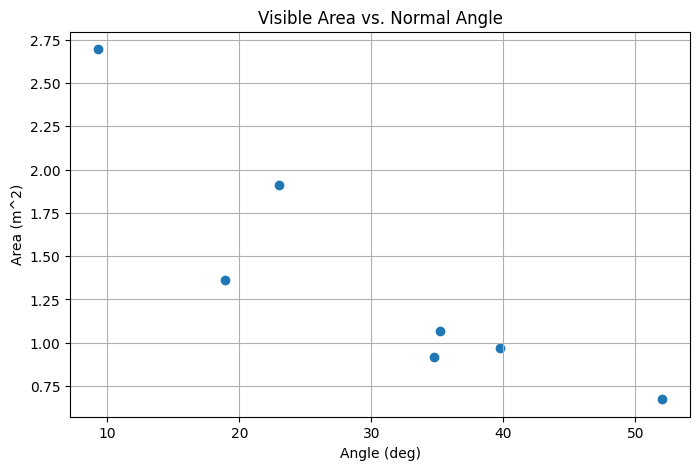

In [18]:
# Step 6: Visualizations

# --- 2D Plot: Area vs. Angle ---
valid_angles = [d['angle_deg'] for d in valid_face_data]
valid_areas = [d['area_m2'] for d in valid_face_data]
plt.figure(figsize=(8, 5))
plt.scatter(valid_angles, valid_areas)
plt.title('Visible Area vs. Normal Angle'), plt.xlabel('Angle (deg)'), plt.ylabel('Area (m^2)')
plt.grid(True), plt.show()

# --- 3D Animation ---
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
axis_line = np.array([-estimated_axis, estimated_axis])
ax.plot(axis_line[:,0], axis_line[:,1], axis_line[:,2], 'r-', lw=2, label='Rotation Axis')
face_plot = ax.scatter([], [], [], s=5)
normal_plot = ax.quiver(0, 0, 0, 0, 0, 0, color='g', length=0.5, normalize=True)

def update(frame):
    points = all_face_points[frame]
    if points is None or points.shape[0] == 0:
        face_plot._offsets3d = ([], [], [])
        normal_plot.set_segments([])
        ax.set_title(f'Frame {frame + 1} (No Face Detected)')
        return face_plot, normal_plot

    data = all_face_data[frame]
    face_plot._offsets3d = (points[:, 0], points[:, 1], points[:, 2])
    centroid = np.mean(points, axis=0)
    normal_plot.set_segments([[centroid, centroid + data['normal']]])
    ax.set_title(f'Frame {frame + 1}')
    return face_plot, normal_plot

all_valid_points = np.concatenate([p for p in all_face_points if p is not None])
min_c, max_c = np.min(all_valid_points, 0), np.max(all_valid_points, 0)
ax.set_xlim(min_c[0]-0.5, max_c[0]+0.5), ax.set_ylim(min_c[1]-0.5, max_c[1]+0.5), ax.set_zlim(min_c[2]-0.5, max_c[2]+0.5)
ax.set_xlabel('X (m)'), ax.set_ylabel('Y (m)'), ax.set_zlabel('Z (m)'), ax.legend()
ax.view_init(elev=20., azim=-35)

ani = FuncAnimation(fig, update, frames=len(depth_images), interval=500, blit=False)
display(HTML(ani.to_html5_video()))
plt.close() # Prevents a static image from appearing below the animation

In [19]:
# Step 6: Visualizations (with Full Box Representation)

from scipy.spatial.transform import Rotation

# --- Part A: Estimate Plausible Box Dimensions ---

valid_angles = [d['angle_deg'] for d in valid_face_data]
best_frame_index = valid_indices[np.argmin(valid_angles)]
best_face_points = all_face_points[best_frame_index]

# Calculate width (X-span) and height (Y-span) from the best view
width = np.max(best_face_points[:, 0]) - np.min(best_face_points[:, 0])
height = np.max(best_face_points[:, 1]) - np.min(best_face_points[:, 1])
# Assume it's a cube for the depth dimension
depth = (width + height) / 2.0

print("\n--- Plausible Box Dimensions ---")
print(f"Estimated from best frame (#{best_frame_index + 1}):")
print(f"Width (X): {width:.2f} m, Height (Y): {height:.2f} m, Assumed Depth (Z): {depth:.2f} m")

# --- Part B: Create the Box Model and Animation ---

# Define the 8 vertices of a centered unit cube
unit_box_verts = np.array([
    [-0.5, -0.5, -0.5], [0.5, -0.5, -0.5], [0.5, 0.5, -0.5], [-0.5, 0.5, -0.5],
    [-0.5, -0.5, 0.5], [0.5, -0.5, 0.5], [0.5, 0.5, 0.5], [-0.5, 0.5, 0.5]
])

# Scale the unit cube to our estimated dimensions
scaled_box_verts = unit_box_verts * np.array([width, height, depth])

# Define the 12 edges of the cube by connecting vertex indices
edges = [
    [0, 1], [1, 2], [2, 3], [3, 0], [4, 5], [5, 6], [6, 7], [7, 4],
    [0, 4], [1, 5], [2, 6], [3, 7]
]

# --- Setup the 3D Plot ---
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# We will draw 12 lines for the box edges. Initialize them.
box_lines = [ax.plot([], [], [], 'b-')[0] for _ in range(12)]
ax.plot([], [], [], 'r-', lw=2, label='Rotation Axis') # Placeholder for legend

# --- New Robust Animation Function ---
def update_box(frame):
    data = all_face_data[frame]
    points = all_face_points[frame]

    if data is None:
        for line in box_lines:
            line.set_data_3d([], [], [])
        ax.set_title(f'Frame {frame + 1} (No Face Detected)')
        return box_lines

    # --- Core Logic: Orient and Position the Box ---
    # 1. Get the target orientation (the normal vector for this frame)
    target_normal = data['normal']
    # Define the reference normal of our box model (e.g., the normal of the front face, Z+)
    reference_normal = np.array([0, 0, -1.0]) # Use -1 since our camera faces -Z

    # 2. Calculate the rotation required to align the reference normal with the target normal
    rotation, _ = Rotation.align_vectors([target_normal], [reference_normal])

    # 3. Apply this rotation to our scaled box model
    rotated_verts = rotation.apply(scaled_box_verts)

    # 4. Translate the rotated box to the position of the detected face
    centroid = np.mean(points, axis=0)
    positioned_verts = rotated_verts + centroid

    # 5. Update the 12 lines (edges) of the box plot
    for i, edge in enumerate(edges):
        # Set the X, Y, and Z data for each edge line
        box_lines[i].set_data_3d(positioned_verts[edge, 0], positioned_verts[edge, 1], positioned_verts[edge, 2])

    ax.set_title(f'Frame {frame + 1}')
    return box_lines

# --- Set plot limits and labels (same as before) ---
all_valid_points = np.concatenate([p for p in all_face_points if p is not None])
min_c, max_c = np.min(all_valid_points, 0), np.max(all_valid_points, 0)
center = (min_c + max_c) / 2
max_range = np.max(max_c - min_c) * 0.7
ax.set_xlim(center[0] - max_range, center[0] + max_range)
ax.set_ylim(center[1] - max_range, center[1] + max_range)
ax.set_zlim(center[2] - max_range, center[2] + max_range)
ax.set_xlabel('X (m)'), ax.set_ylabel('Y (m)'), ax.set_zlabel('Z (m)'), ax.legend()
ax.view_init(elev=20., azim=-35)

# --- Create and Display the Animation ---
ani_box = FuncAnimation(fig, update_box, frames=len(depth_images), interval=500, blit=False)
display(HTML(ani_box.to_html5_video()))
plt.close()


--- Plausible Box Dimensions ---
Estimated from best frame (#2):
Width (X): 1.80 m, Height (Y): 1.75 m, Assumed Depth (Z): 1.77 m


In [21]:
# Step 6: Visualizations (with Stable Center Full Box Representation)

from scipy.spatial.transform import Rotation
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from mpl_toolkits.mplot3d import Axes3D
from IPython.display import HTML
import numpy as np

# --- Part A: Estimate Plausible Box Dimensions (No change here) ---
valid_indices = [i for i, data in enumerate(all_face_data) if data is not None]
valid_angles = [all_face_data[i]['angle_deg'] for i in valid_indices]
best_frame_index = valid_indices[np.argmin(valid_angles)]
best_face_points = all_face_points[best_frame_index]

width = np.max(best_face_points[:, 0]) - np.min(best_face_points[:, 0])
height = np.max(best_face_points[:, 1]) - np.min(best_face_points[:, 1])
depth = (width + height) / 2.0

print("\n--- Plausible Box Dimensions ---")
print(f"Estimated from best frame (#{best_frame_index + 1}):")
print(f"Width (X): {width:.2f} m, Height (Y): {height:.2f} m, Assumed Depth (Z): {depth:.2f} m")

# --- Part B: NEW - Estimate a Stable Center for the Box ---
all_centroids = [np.mean(all_face_points[i], axis=0) for i in valid_indices]
stable_center = np.mean(all_centroids, axis=0)
print(f"\nEstimated Stable Center: {np.array2string(stable_center, precision=2)} m")


# --- Part C: Create the Box Model and Animation ---
unit_box_verts = np.array([
    [-0.5, -0.5, -0.5], [0.5, -0.5, -0.5], [0.5, 0.5, -0.5], [-0.5, 0.5, -0.5],
    [-0.5, -0.5, 0.5], [0.5, -0.5, 0.5], [0.5, 0.5, 0.5], [-0.5, 0.5, 0.5]
])
scaled_box_verts = unit_box_verts * np.array([width, height, depth])
edges = [
    [0, 1], [1, 2], [2, 3], [3, 0], [4, 5], [5, 6], [6, 7], [7, 4],
    [0, 4], [1, 5], [2, 6], [3, 7]
]

# Setup the plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
box_lines = [ax.plot([], [], [], 'b-')[0] for _ in range(12)]
ax.plot([], [], [], 'r-', lw=2, label='Rotation Axis') # Placeholder for legend

# --- UPDATED Animation Function (uses stable_center) ---
def update_box_stable(frame):
    data = all_face_data[frame]

    if data is None:
        for line in box_lines:
            line.set_data_3d([], [], [])
        ax.set_title(f'Frame {frame + 1} (No Face Detected)')
        return box_lines

    target_normal = data['normal']
    reference_normal = np.array([0, 0, -1.0])
    rotation, _ = Rotation.align_vectors([target_normal], [reference_normal])

    # Apply rotation and translate to the STABLE center
    rotated_verts = rotation.apply(scaled_box_verts)
    positioned_verts = rotated_verts + stable_center # USE STABLE CENTER HERE

    # Update the 12 edge lines
    for i, edge in enumerate(edges):
        box_lines[i].set_data_3d(positioned_verts[edge, 0], positioned_verts[edge, 1], positioned_verts[edge, 2])

    ax.set_title(f'Frame {frame + 1}')
    return box_lines

# --- Set plot limits and labels (No change here) ---
all_valid_points = np.concatenate([p for p in all_face_points if p is not None])
min_c, max_c = np.min(all_valid_points, 0), np.max(all_valid_points, 0)
center = (min_c + max_c) / 2
max_range = np.max(max_c - min_c) * 1.0 # Increased range slightly
ax.set_xlim(center[0] - max_range, center[0] + max_range)
ax.set_ylim(center[1] - max_range, center[1] + max_range)
ax.set_zlim(center[2] - max_range, center[2] + max_range)
ax.set_xlabel('X (m)'), ax.set_ylabel('Y (m)'), ax.set_zlabel('Z (m)'), ax.legend()
ax.view_init(elev=20., azim=-35)

# --- Create and Display the Animation ---
ani_box = FuncAnimation(fig, update_box_stable, frames=len(depth_images), interval=500, blit=False)
display(HTML(ani_box.to_html5_video()))
plt.close()


--- Plausible Box Dimensions ---
Estimated from best frame (#2):
Width (X): 1.80 m, Height (Y): 1.75 m, Assumed Depth (Z): 1.77 m

Estimated Stable Center: [0.22 0.03 1.03] m


** PCA Algorithm**
This single block of code contains all the features we've developed, including the stable visualization and the improved PCA analysis

In [22]:
# Step 1: Install and Import Libraries

import numpy as np
from pathlib import Path
from rosbags.highlevel import AnyReader
from sklearn.linear_model import RANSACRegressor
from sklearn.decomposition import PCA # <-- Added PCA import
from scipy.spatial import ConvexHull
from scipy.spatial.transform import Rotation
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from mpl_toolkits.mplot3d import Axes3D
from IPython.display import HTML

In [23]:
# Step 2: Helper Functions

def ros_image_to_numpy(msg):
    """Converts a ROS sensor_msgs/Image to a NumPy array, supporting 16UC1."""
    if msg.encoding == '16UC1':
        return np.frombuffer(msg.data, dtype=np.uint16).reshape(msg.height, msg.width)
    elif msg.encoding == '32FC1':
        return np.frombuffer(msg.data, dtype=np.float32).reshape(msg.height, msg.width)
    else:
        raise NotImplementedError(f"Encoding '{msg.encoding}' is not supported.")

def depth_to_point_cloud(depth_image, fx, fy, cx, cy):
    """Converts a depth image to a 3D point cloud, converting mm to meters."""
    points = []
    height, width = depth_image.shape
    for v in range(height):
        for u in range(width):
            d = depth_image[v, u]
            if d > 0:
                z = d / 1000.0
                x = (u - cx) * z / fx
                y = (v - cy) * z / fy
                points.append([x, y, z])
    return np.array(points)

In [24]:
# Step 3: Load Data from ROS Bag
bag_path = Path('.')
depth_images, timestamps = [], []
try:
    with AnyReader([bag_path]) as reader:
        connections = [x for x in reader.connections if x.topic == '/depth']
        if not connections:
            raise RuntimeError("No messages found on the /depth topic.")
        for connection, timestamp, rawdata in reader.messages(connections=connections):
            msg = reader.deserialize(rawdata, connection.msgtype)
            depth_images.append(ros_image_to_numpy(msg))
            timestamps.append(timestamp)
    print(f"Successfully loaded {len(depth_images)} images from the ROS bag.")
except Exception as e:
    print(f"Error reading ROS bag: {e}")

Successfully loaded 7 images from the ROS bag.


In [25]:
# Step 4: Robustly Process Each Image

all_face_data, all_face_points = [], []
if depth_images:
    height, width = depth_images[0].shape
    fx, fy, cx, cy = width / 2.0, width / 2.0, width / 2.0, height / 2.0

    for i, depth_image in enumerate(depth_images):
        point_cloud = depth_to_point_cloud(depth_image, fx, fy, cx, cy)
        if point_cloud.shape[0] > 0:
            median_z = np.median(point_cloud[:, 2])
            mask = np.abs(point_cloud[:, 2] - median_z) < 0.25
            point_cloud = point_cloud[mask]

        if point_cloud.shape[0] < 20:
            all_face_data.append(None); all_face_points.append(None); continue

        ransac = RANSACRegressor(residual_threshold=0.01).fit(point_cloud[:, 0:2], point_cloud[:, 2])
        face_points = point_cloud[ransac.inlier_mask_]

        if len(face_points) < 20:
            all_face_data.append(None); all_face_points.append(None); continue

        all_face_points.append(face_points)
        a, b = ransac.estimator_.coef_
        normal = np.array([a, b, -1.0]); normal /= np.linalg.norm(normal)
        if normal[2] > 0: normal = -normal
        dot_prod = np.clip(np.dot(normal, np.array([0, 0, -1.0])), -1.0, 1.0)
        angle = np.rad2deg(np.arccos(dot_prod))
        area = ConvexHull(face_points[:, 0:2]).volume
        all_face_data.append({"normal": normal, "angle_deg": angle, "area_m2": area})
    print("Successfully processed all frames.")


Successfully processed all frames.


In [26]:
# Step 5: Final Analysis and Outputs (with PCA Algorithm)
valid_indices = [i for i, data in enumerate(all_face_data) if data is not None]
valid_face_data = [all_face_data[i] for i in valid_indices]

# --- NEW ALGORITHM: Calculate Rotation Axis using PCA ---
if len(valid_face_data) > 2:
    valid_normals = [d['normal'] for d in valid_face_data]
    pca = PCA(n_components=3).fit(valid_normals)
    # The axis of rotation is the principal component with the smallest variance
    estimated_axis = pca.components_[2]
    estimated_axis /= np.linalg.norm(estimated_axis)
else:
    estimated_axis = np.array([0,0,0])

# --- Calculate Angular Velocity ---
angular_velocities = []
for i in range(len(valid_indices) - 1):
    idx1, idx2 = valid_indices[i], valid_indices[i+1]
    n1, n2 = all_face_data[idx1]["normal"], all_face_data[idx2]["normal"]
    t1, t2 = timestamps[idx1], timestamps[idx2]
    delta_angle = np.arccos(np.clip(np.dot(n1, n2), -1.0, 1.0))
    delta_time = (t2 - t1) / 1e9
    if delta_time > 0: angular_velocities.append(delta_angle / delta_time)
avg_omega = np.mean(angular_velocities) if angular_velocities else 0

# --- Print Final Table and Analysis ---
print("\n--- Final Results Table ---")
print("Image | Normal Angle (deg) | Visible Area (m^2)")
print("--------------------------------------------------")
for i, data in enumerate(all_face_data):
    if data: print(f"{i+1:5d} | {data['angle_deg']:19.2f} | {data['area_m2']:18.4f}")
    else: print(f"{i+1:5d} | {'--':>19} | {'--':>18}")

print("\n--- Further Analysis ---")
print(f"Robust Rotation Axis (PCA): {np.array2string(estimated_axis, precision=4)}")
print(f"Estimated Avg Angular Velocity: {avg_omega:.2f} rad/s")
np.savetxt('rotation_axis.txt', estimated_axis, header='[X, Y, Z]')



--- Final Results Table ---
Image | Normal Angle (deg) | Visible Area (m^2)
--------------------------------------------------
    1 |               52.55 |             0.6573
    2 |                9.01 |             2.6834
    3 |               22.64 |             1.9529
    4 |               37.75 |             0.9922
    5 |               19.36 |             1.4362
    6 |               35.09 |             1.0553
    7 |               35.70 |             0.8844

--- Further Analysis ---
Robust Rotation Axis (PCA): [ 0.9986 -0.0249 -0.0465]
Estimated Avg Angular Velocity: 0.46 rad/s


In [27]:
# Step 6: Visualizations (with Stable Center and PCA Axis)
# --- Estimate Box Dimensions and Stable Center ---
valid_angles = [d['angle_deg'] for d in valid_face_data]
best_frame_idx = valid_indices[np.argmin(valid_angles)]
best_face_pts = all_face_points[best_frame_idx]
width = np.ptp(best_face_pts[:, 0]); height = np.ptp(best_face_pts[:, 1]); depth = (width + height) / 2.0
all_centroids = [np.mean(all_face_points[i], axis=0) for i in valid_indices]
stable_center = np.mean(all_centroids, axis=0)

# --- Create Box Model ---
unit_verts = np.array([[-.5,-.5,-.5],[.5,-.5,-.5],[.5,.5,-.5],[-.5,.5,-.5],[-.5,-.5,.5],[.5,-.5,.5],[.5,.5,.5],[-.5,.5,.5]])
scaled_verts = unit_verts * np.array([width, height, depth])
edges = [[0,1],[1,2],[2,3],[3,0],[4,5],[5,6],[6,7],[7,4],[0,4],[1,5],[2,6],[3,7]]

# --- Setup Plot ---
fig = plt.figure(figsize=(10, 8)); ax = fig.add_subplot(111, projection='3d')
box_lines = [ax.plot([],[],[], 'b-')[0] for _ in edges]
ax.plot([],[],[], 'r-', lw=2, label='Rotation Axis (PCA)')

# --- Animation Function ---
def update_box_final(frame):
    if all_face_data[frame] is None:
        for line in box_lines: line.set_data_3d([],[],[])
        ax.set_title(f'Frame {frame + 1} (No Face Detected)')
        return box_lines

    target_normal = all_face_data[frame]['normal']
    rot, _ = Rotation.align_vectors([target_normal], [np.array([0,0,-1.])])
    positioned_verts = rot.apply(scaled_verts) + stable_center

    for i, edge in enumerate(edges):
        box_lines[i].set_data_3d(positioned_verts[edge, 0], positioned_verts[edge, 1], positioned_verts[edge, 2])
    ax.set_title(f'Frame {frame + 1}')
    return box_lines

# --- Set plot limits and display ---
all_valid_pts = np.concatenate([p for p in all_face_points if p is not None])
min_c, max_c = np.min(all_valid_pts,0), np.max(all_valid_pts,0)
center = (min_c+max_c)/2; max_range = np.max(max_c-min_c)*1.0
ax.set_xlim(center[0]-max_range,center[0]+max_range); ax.set_ylim(center[1]-max_range,center[1]+max_range); ax.set_zlim(center[2]-max_range,center[2]+max_range)
ax.set_xlabel('X(m)'); ax.set_ylabel('Y(m)'); ax.set_zlabel('Z(m)'); ax.legend()
ax.view_init(elev=20., azim=-35)

# --- Create and Display Animation ---
ani_box = FuncAnimation(fig, update_box_final, frames=len(depth_images), interval=500, blit=False)
display(HTML(ani_box.to_html5_video()))
plt.close()